# Question 2 work in the Gurmukhi Dataset

## Checking Avilable GPU

In [328]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Importing requirements

In [329]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy

## device agnostic code

In [330]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Getting Dataset with pytorch

### Downloading Dataset

In [331]:
# !rm -rf data/

In [332]:
file_id = "1DXLTrDU0GgHt2yLoDyMfdECHV-2yNvjQ"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

import requests
from pathlib import Path
import zipfile
import os

# making paths for the data
data_path = Path("data")
img_path = data_path / "Gurmukhi"

img_path.mkdir(parents=True,exist_ok=True)

if not (img_path/"GurNum").is_dir():
  print("creating folder/dirs")
  # getting data from the url
  res = requests.get(url)
  # checking response
  print(f"status_code: {res.status_code}")
  if res.status_code == 200:
    print("downloading the data...")
    with open(img_path/"Gurmukhi.zip","wb") as f:
      # print(res.content)
      f.write(res.content)
      zip_file_path = img_path/"Gurmukhi.zip"
      print(zip_file_path)
    with zipfile.ZipFile(zip_file_path,"r") as zipfile:
      print("Extracting file")
      zipfile.extractall(img_path)
      print(f"All file extracted to {img_path}")
      print("Removing zip file")
      os.remove(zip_file_path)
  else:
    print(f"GOT NO RESPONSE FROM URL: {url}")

  # renamaing val to test to follow PyTorch convention
  print("renamaing val to test")
  os.rename(f"{img_path}/GurNum/val",f"{img_path}/GurNum/test")
else:
  print('skiping already exists')

skiping already exists


In [333]:
train_dir = img_path / "GurNum/train"
test_dir = img_path / "GurNum/test"

train_dir,test_dir

(PosixPath('data/Gurmukhi/GurNum/train'),
 PosixPath('data/Gurmukhi/GurNum/test'))

In [334]:
from torchvision import transforms

image_trasform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.ImageFolder(
    root = train_dir,
    transform = image_trasform
)

test_dataset = torchvision.datasets.ImageFolder(
    root = test_dir,
    transform = image_trasform
)
train_dataset,test_dataset

(Dataset ImageFolder
     Number of datapoints: 1000
     Root location: data/Gurmukhi/GurNum/train
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=1)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 178
     Root location: data/Gurmukhi/GurNum/test
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=1)
                ToTensor()
            ))

### Vis. dataset (train dataset)

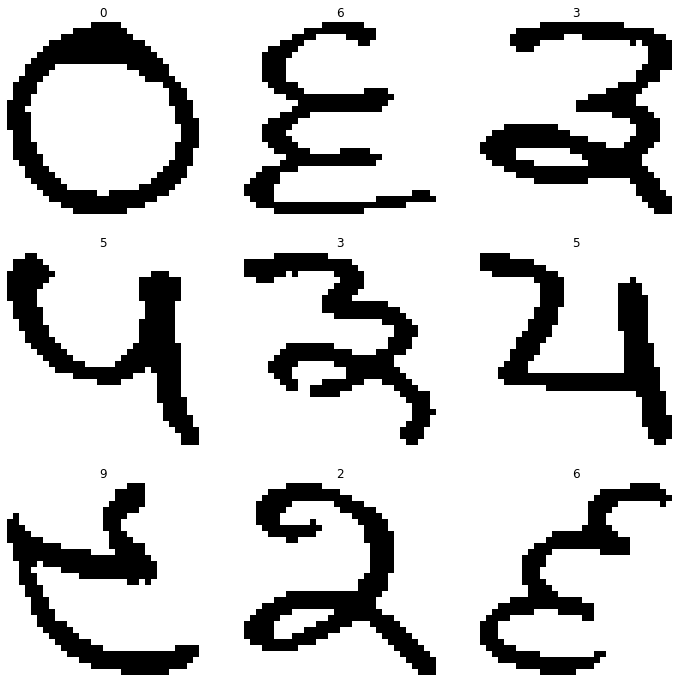

In [335]:
# randomly ploting image samples from the grayscale dataset
labels_map = test_dataset.class_to_idx # getting class -> index map
labels_map = dict(map(reversed, labels_map.items())) # inverting dict
# print(labels_map)

figure = plt.figure(figsize=(12, 12)) # fixing plotsize
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)) # randomely selecting one image sample from the image index
    img, label = train_dataset[sample_idx] # getting image and label of selected index
    # sub plot code
    figure.add_subplot(rows, cols, i) 
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap="gray") # NOTE:- Color map is gray because we're converting imgae to grayscale
    # sub plot code ends
plt.show()

### Converting dataset to dataloader

In [336]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() # no. of avilable cpu cores

# train dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers =  NUM_WORKERS   
)

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers =  NUM_WORKERS   
)

print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")
# train_dataloader,test_dataloader

Numbers of Batches in Train Dataloader: 32
Numbers of Batches in Test Dataloader: 6


## plot loss and accuracy graphs function

In [337]:
from typing import Dict,List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

## Defining models

In [338]:
class MyDropout(nn.Module):
    def __init__(self, p: float = 0):
      """
      args:
        p (float) = 0: prob. of droping a node from the layer
      """
      super().__init__()
      # prob. checking
      if p < 0 or p > 1:
          raise ValueError(f"dropout prob. out of range (0-1), but got {p}")
      self.p = p

    def forward(self, X):
        if self.training:
            binomial = torch.distributions.binomial.Binomial(probs=1-self.p)
            return X * binomial.sample(X.size()) * (1.0/(1-self.p))
        return X

In [339]:
class GurNumModel0(nn.Module):
  def __init__(
      self,
      in_channels:int,
      hidden_units:int,
      out_channels:int,
      num_layers:int,
      activation_funtion:nn.Module,
      use_drop_prob: float = 0
      ) -> None:
    '''
    args:
      in_channels: input image shape
      hidden_units: number of hidden in neural net.
      out_channels: number of classes in the data
      num_layers: number of layers including i/p and o/p layers
      actication_function: activation function of your choice
      use_drop_prob = 0: to use drop with prob. of value of it
    '''
    super().__init__()
    self.num_layers = num_layers # no of layers in the neural net.
    layer_list = [nn.Flatten()]
    for i in range(num_layers):
      # print(f"creating layer: {i}, out of: {num_layers}")
      if i == 0: # input layer def.
        layer_list.append(nn.Linear(in_features=in_channels,out_features=hidden_units))
        layer_list.append(activation_funtion)
        layer_list.append(MyDropout(p=use_drop_prob))
      elif i == num_layers - 1: # out layer def.
        layer_list.append(nn.Linear(in_features=hidden_units,out_features=out_channels))
      else:
        layer_list.append(nn.Linear(in_features=hidden_units,out_features=hidden_units))
        layer_list.append(activation_funtion)
        layer_list.append(MyDropout(p=use_drop_prob))
    
    # print("layer list:")
    # print(*layer_list,sep = '\n')
    self.block = nn.Sequential(*layer_list)

  def forward(self,x:torch.Tensor):
    return self.block(x)


## Training models

### set seeds function

In [340]:
### set seed function
def set_seed(seed:int = 42):
  """
    sets mannual seeds for both cpu and cuda
  """
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

### making training, testing steps, train model functions and custom loss functions with L1 and L2 regularization

#### train step

In [341]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
    regularizer = None,
    cheack_grad = False,
    ):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
      regularizer (function) = None: A penalty function
      cheack_grad (False) = False: to do gradiant checking during training
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train() # putting model in traing model

    train_loss, train_acc = 0, 0 # initlizing loss and acc. for the epoch
    set_flag = False 

    # print(type(model.parameters()))
    for (X,y) in dataloader: # loop in batches
      # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
      X,y = X.to(device), y.to(device) # sending the data to target device
      # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
      
      # 1. forward pass
      y_pred_logits = model(X)

      # cumulating tensors to theta
      if cheack_grad:
        # making theta
        if next(iter(model.parameters())).grad != None:
          theta = np.array([i.grad.detach().numpy() for i in model.parameters()])
        else:
          set_flag = True
          theta = np.zeros(next(iter(model.parameters())).shape)
        # print(type(theta))
        epsilon = np.ones(theta.shape) * 1e-7
        # print(epsilon)
        thetaplus = theta+epsilon
        thetaminus = theta-epsilon

        grad_approx = (thetaplus - thetaminus)
        # print(dtheta_approx)
        
      # 2. calculate the loss
      
      # loss = loss_fn(y_pred_logits, y) + l1_penalty(model.parameters())
      if regularizer != None:
        # print("using regularizer")
        loss = loss_fn(y_pred_logits, y) + regularizer(model.parameters())
      else:
        loss = loss_fn(y_pred_logits, y)
      train_loss += loss.item()

      # 3. optimizer zero grad
      optimizer.zero_grad()

      # 4. loss backword
      loss.backward()
      
      # 5. optimizer step
      optimizer.step()

        

      # model_parms_after_forward_pass = np.array([x.detach().numpy() for x in model.parameters()])
      # print("Model parms diff:")
      # print([(i,j) for (i,j) in zip(iter(model_parms_after_forward_pass),iter(model_parms_before_forward_pass))])
      # print(model_parms_after_forward_pass - model_parms_before_forward_pass,sep="\n")
      train_acc += acc_fn(y_pred_logits.argmax(dim = 1), y).item()

      if cheack_grad:
        if set_flag:
          continue
        grad_approx = theta
        actual_grad = np.array([i.grad.detach().numpy() for i in model.parameters()])
        grad_diff = grad_approx - actual_grad
        nm = np.average([np.linalg.norm(i) for i in grad_diff])
        dm = (np.average([np.linalg.norm(i) in actual_grad]) + np.average([np.linalg.norm(i) for i in grad_approx]))/2
        
        diff = (nm / dm)
        if diff < 1e-7:
          pass
        else:
          # if grad cheak fails the code will stops 
          raise ValueError("Invalid gradient computation")
    # 6. returning actual loss and acc.x
    return train_loss/len(dataloader), train_acc/len(dataloader)



#### test step

In [342]:
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str
    ):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval() # putting model in eval model

    test_loss, test_acc = 0, 0 # initlizing loss and acc. for the epoch

    with torch.inference_mode():
      for (X,y) in dataloader: # loop in batches
        X,y = X.to(device), y.to(device) # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits.argmax(dim = 1), y).item()

    # 6. returning actual loss and acc.
    return test_loss/len(dataloader), test_acc/len(dataloader)

#### training function

In [343]:
from tqdm.auto import tqdm

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
    epochs: int,
    regularizer = None,
    cheack_grad=False
  ):
  """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      regularizer (function) = None: A penalty function
      cheack_grad (False) = False: to do gradiant checking during training
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
  """
  # 1. init. result dict
  result_dict = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }
  
  # 2. loop in range epochs performs train and test steps on the model
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = training_step(
                                            model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            acc_fn=acc_fn,
                                            optimizer=optimizer,
                                            device=device,
                                            regularizer=regularizer,
                                            cheack_grad=cheack_grad
                                          )

    test_loss, test_acc = testing_step(
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        acc_fn=acc_fn,
                                        device=device
                                      )
  
  # 3. print out results
    print(
              f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
          )
    
  # 4. adding results to result_dict
    result_dict["train_loss"].append(train_loss)
    result_dict["train_acc"].append(train_acc)
    result_dict["test_loss"].append(test_loss)
    result_dict["test_acc"].append(test_acc)

  # 5. return result dict
  return result_dict

#### Penalty with L1 regularization

In [344]:
def l1_penalty(params: torch.Tensor, l1_lambda:float = 0.001):
    """
    Desc:
      Calculte the penalty with L1 norm.
      
    Args:
      params (torch.Tensor): training model parameters
      l1_lambda (float) = 10e-3: scaler multiplyer default value:- 10e-3

    Returns:
      Returns the L1 penalty of the params.
    """
    l1_norm = 0
    for param in params:
      l1_norm += torch.linalg.norm(param,1) ** 2
    return l1_lambda*l1_norm

#### Penalty with L2 regularization

In [345]:
def l2_penalty(params: torch.Tensor, l2_lambda:float = 0.001):
    """
    Desc:
      Calculte the penalty with L2 norm.
      
    Args:
      params (torch.Tensor): training model parameters
      l2_lambda (float) = 10e-3: scaler multiplyer default value:- 10e-3

    Returns:
      Returns the L2 penalty of the params.
    """
    l2_norm = 0
    for param in params:
      l2_norm += torch.linalg.norm(param,2) ** 2
    return l2_lambda*l2_norm

### making model object

In [346]:
height = next(iter(train_dataloader))[0].shape[2]
width = next(iter(train_dataloader))[0].shape[2]
height,width

(32, 32)

In [347]:
class_names = train_dataloader.dataset.classes
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [348]:
set_seed()
model_sigmoid_3_layers = GurNumModel0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = 3,
    activation_funtion = nn.Sigmoid()
    ).to(device)
print("\nMODEL INFO: \n")
print(model_sigmoid_3_layers)


MODEL INFO: 

GurNumModel0(
  (block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=16, bias=True)
    (2): Sigmoid()
    (3): MyDropout()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Sigmoid()
    (6): MyDropout()
    (7): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [349]:
set_seed()
model_tanh_3_layers = GurNumModel0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = 3,
    activation_funtion = nn.Tanh()
    ).to(device)
print("\nMODEL INFO: \n")
print(model_tanh_3_layers)


MODEL INFO: 

GurNumModel0(
  (block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=16, bias=True)
    (2): Tanh()
    (3): MyDropout()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Tanh()
    (6): MyDropout()
    (7): Linear(in_features=16, out_features=10, bias=True)
  )
)


### training model_sigmode_3_layers without regularization

In [350]:
# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
# loss_fn = mcross_entropy_loss_with_L1()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_sigmoid_3_layers.parameters(), lr=0.001)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_sigmoid_3_layer_results = train(model=model_sigmoid_3_layers, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        device=device,
                        loss_fn=loss_fn, 
                        acc_fn=acc_fn,
                        epochs=NUM_EPOCHS)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3096 | train_acc: 0.1641 | test_loss: 2.2596 | test_acc: 0.1875
Epoch: 2 | train_loss: 2.2297 | train_acc: 0.2388 | test_loss: 2.2017 | test_acc: 0.2772
Epoch: 3 | train_loss: 2.1768 | train_acc: 0.3159 | test_loss: 2.1505 | test_acc: 0.3827
Epoch: 4 | train_loss: 2.1240 | train_acc: 0.5032 | test_loss: 2.0901 | test_acc: 0.6121
Epoch: 5 | train_loss: 2.0627 | train_acc: 0.6572 | test_loss: 2.0289 | test_acc: 0.7116
Epoch: 6 | train_loss: 1.9985 | train_acc: 0.7279 | test_loss: 1.9585 | test_acc: 0.7513
Epoch: 7 | train_loss: 1.9256 | train_acc: 0.7524 | test_loss: 1.8872 | test_acc: 0.7684
Epoch: 8 | train_loss: 1.8511 | train_acc: 0.7587 | test_loss: 1.8063 | test_acc: 0.7533
Epoch: 9 | train_loss: 1.7721 | train_acc: 0.7410 | test_loss: 1.7280 | test_acc: 0.7458
Epoch: 10 | train_loss: 1.6906 | train_acc: 0.7600 | test_loss: 1.6446 | test_acc: 0.7809
Epoch: 11 | train_loss: 1.6051 | train_acc: 0.8038 | test_loss: 1.5583 | test_acc: 0.7914
Epoch: 12 | train_l

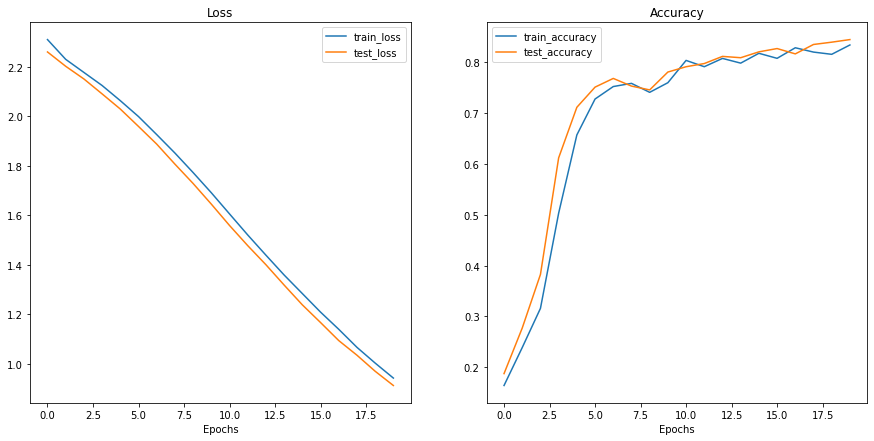

In [351]:
plot_loss_curves(model_sigmoid_3_layer_results)

### training model_tanh_3_layers without regularization

In [352]:
# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_tanh_3_layers.parameters(), lr=0.001)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_tanh_3_layer_results = train(model=model_tanh_3_layers, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        device=device,
                        loss_fn=loss_fn, 
                        acc_fn=acc_fn,
                        epochs=NUM_EPOCHS)


# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9821 | train_acc: 0.4414 | test_loss: 1.7151 | test_acc: 0.5905
Epoch: 2 | train_loss: 1.5498 | train_acc: 0.7051 | test_loss: 1.3751 | test_acc: 0.7741
Epoch: 3 | train_loss: 1.2483 | train_acc: 0.7977 | test_loss: 1.1013 | test_acc: 0.8424
Epoch: 4 | train_loss: 0.9997 | train_acc: 0.8650 | test_loss: 0.8892 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.8178 | train_acc: 0.8457 | test_loss: 0.7227 | test_acc: 0.8935
Epoch: 6 | train_loss: 0.6569 | train_acc: 0.8799 | test_loss: 0.5865 | test_acc: 0.8899
Epoch: 7 | train_loss: 0.5339 | train_acc: 0.9134 | test_loss: 0.4676 | test_acc: 0.9200
Epoch: 8 | train_loss: 0.4436 | train_acc: 0.9174 | test_loss: 0.3983 | test_acc: 0.9245
Epoch: 9 | train_loss: 0.3680 | train_acc: 0.9064 | test_loss: 0.3487 | test_acc: 0.9347
Epoch: 10 | train_loss: 0.3156 | train_acc: 0.9176 | test_loss: 0.2873 | test_acc: 0.9429
Epoch: 11 | train_loss: 0.2634 | train_acc: 0.9165 | test_loss: 0.2354 | test_acc: 0.9319
Epoch: 12 | train_l

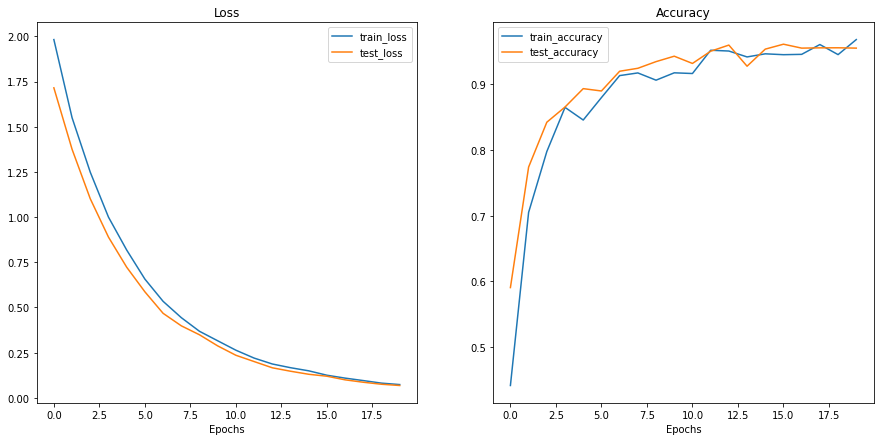

In [353]:
plot_loss_curves(model_tanh_3_layer_results)

### making model object

In [354]:
set_seed()
model_sigmoid_3_layers = GurNumModel0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = 3,
    activation_funtion = nn.Sigmoid()
    ).to(device)
print("\nMODEL INFO: \n")
print(model_sigmoid_3_layers)


MODEL INFO: 

GurNumModel0(
  (block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=16, bias=True)
    (2): Sigmoid()
    (3): MyDropout()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Sigmoid()
    (6): MyDropout()
    (7): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [355]:
set_seed()
model_tanh_3_layers = GurNumModel0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = 3,
    activation_funtion = nn.Tanh()
    ).to(device)
print("\nMODEL INFO: \n")
print(model_tanh_3_layers)


MODEL INFO: 

GurNumModel0(
  (block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=16, bias=True)
    (2): Tanh()
    (3): MyDropout()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Tanh()
    (6): MyDropout()
    (7): Linear(in_features=16, out_features=10, bias=True)
  )
)


### train loop for model_sigmode_3_layers with l1 regularization

In [356]:
# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
# loss_fn = mcross_entropy_loss_with_L1()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_sigmoid_3_layers.parameters(), lr=0.001)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_sigmoid_3_layer_results = train(model=model_sigmoid_3_layers, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        device=device,
                        loss_fn=loss_fn, 
                        acc_fn=acc_fn,
                        epochs=NUM_EPOCHS,
                        regularizer=l1_penalty)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3229 | train_acc: 0.1641 | test_loss: 2.2609 | test_acc: 0.1875
Epoch: 2 | train_loss: 2.2437 | train_acc: 0.2353 | test_loss: 2.2047 | test_acc: 0.2757
Epoch: 3 | train_loss: 2.1934 | train_acc: 0.3101 | test_loss: 2.1560 | test_acc: 0.3913
Epoch: 4 | train_loss: 2.1441 | train_acc: 0.4952 | test_loss: 2.0988 | test_acc: 0.6095
Epoch: 5 | train_loss: 2.0874 | train_acc: 0.6569 | test_loss: 2.0407 | test_acc: 0.7119
Epoch: 6 | train_loss: 2.0288 | train_acc: 0.7311 | test_loss: 1.9745 | test_acc: 0.7477
Epoch: 7 | train_loss: 1.9623 | train_acc: 0.7562 | test_loss: 1.9071 | test_acc: 0.7714
Epoch: 8 | train_loss: 1.8945 | train_acc: 0.7576 | test_loss: 1.8302 | test_acc: 0.7530
Epoch: 9 | train_loss: 1.8223 | train_acc: 0.7414 | test_loss: 1.7558 | test_acc: 0.7469
Epoch: 10 | train_loss: 1.7480 | train_acc: 0.7596 | test_loss: 1.6760 | test_acc: 0.7843
Epoch: 11 | train_loss: 1.6694 | train_acc: 0.8051 | test_loss: 1.5933 | test_acc: 0.7917
Epoch: 12 | train_l

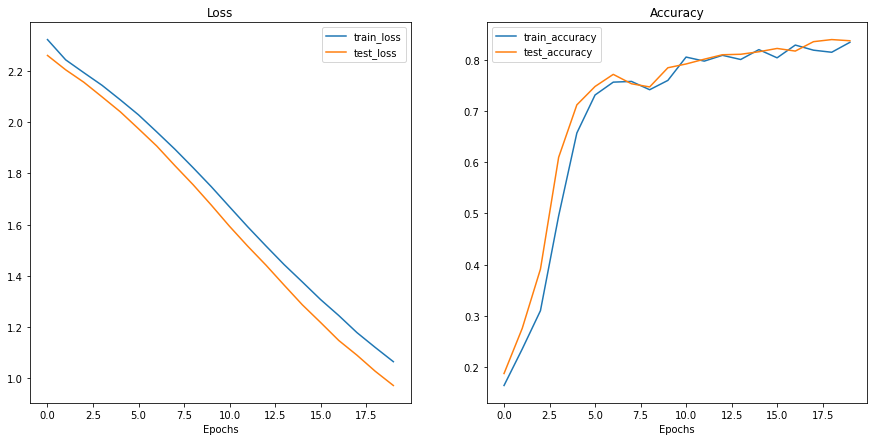

In [357]:
plot_loss_curves(model_sigmoid_3_layer_results)

### training model_tanh_3_layers with l1 regularization

In [358]:
# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_tanh_3_layers.parameters(), lr=0.001)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_tanh_3_layer_results = train(model=model_tanh_3_layers, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        device=device,
                        loss_fn=loss_fn, 
                        acc_fn=acc_fn,
                        epochs=NUM_EPOCHS,
                        regularizer=l1_penalty)


# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9964 | train_acc: 0.4422 | test_loss: 1.7164 | test_acc: 0.5917
Epoch: 2 | train_loss: 1.5660 | train_acc: 0.7053 | test_loss: 1.3771 | test_acc: 0.7747
Epoch: 3 | train_loss: 1.2661 | train_acc: 0.7989 | test_loss: 1.1037 | test_acc: 0.8439
Epoch: 4 | train_loss: 1.0191 | train_acc: 0.8655 | test_loss: 0.8912 | test_acc: 0.8666
Epoch: 5 | train_loss: 0.8390 | train_acc: 0.8462 | test_loss: 0.7236 | test_acc: 0.8919
Epoch: 6 | train_loss: 0.6796 | train_acc: 0.8799 | test_loss: 0.5881 | test_acc: 0.8889
Epoch: 7 | train_loss: 0.5592 | train_acc: 0.9131 | test_loss: 0.4701 | test_acc: 0.9200
Epoch: 8 | train_loss: 0.4707 | train_acc: 0.9174 | test_loss: 0.4020 | test_acc: 0.9255
Epoch: 9 | train_loss: 0.3976 | train_acc: 0.9060 | test_loss: 0.3529 | test_acc: 0.9347
Epoch: 10 | train_loss: 0.3471 | train_acc: 0.9184 | test_loss: 0.2901 | test_acc: 0.9429
Epoch: 11 | train_loss: 0.2963 | train_acc: 0.9168 | test_loss: 0.2400 | test_acc: 0.9319
Epoch: 12 | train_l

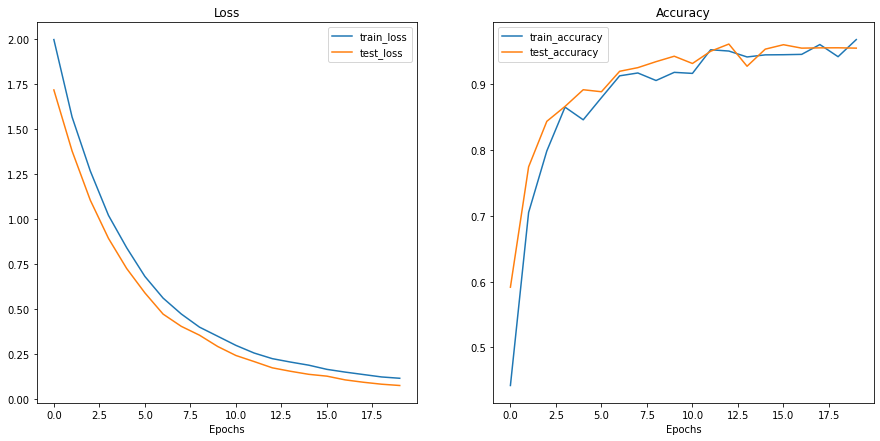

In [359]:
plot_loss_curves(model_tanh_3_layer_results)

### making model object

In [360]:
set_seed()
model_sigmoid_3_layers = GurNumModel0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = 3,
    activation_funtion = nn.Sigmoid()
    ).to(device)
print("\nMODEL INFO: \n")
print(model_sigmoid_3_layers)


MODEL INFO: 

GurNumModel0(
  (block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=16, bias=True)
    (2): Sigmoid()
    (3): MyDropout()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Sigmoid()
    (6): MyDropout()
    (7): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [361]:
set_seed()
model_tanh_3_layers = GurNumModel0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = 3,
    activation_funtion = nn.Tanh()
    ).to(device)
print("\nMODEL INFO: \n")
print(model_tanh_3_layers)


MODEL INFO: 

GurNumModel0(
  (block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=16, bias=True)
    (2): Tanh()
    (3): MyDropout()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Tanh()
    (6): MyDropout()
    (7): Linear(in_features=16, out_features=10, bias=True)
  )
)


### training model_sigmode_3_layers with l2 regularization

In [362]:
# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
# loss_fn = mcross_entropy_loss_with_L1()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_sigmoid_3_layers.parameters(), lr=0.001)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_sigmoid_3_layer_results = train(model=model_sigmoid_3_layers, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        device=device,
                        loss_fn=loss_fn, 
                        acc_fn=acc_fn,
                        epochs=NUM_EPOCHS,
                        regularizer=l2_penalty)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3131 | train_acc: 0.1641 | test_loss: 2.2604 | test_acc: 0.1875
Epoch: 2 | train_loss: 2.2359 | train_acc: 0.2353 | test_loss: 2.2038 | test_acc: 0.2757
Epoch: 3 | train_loss: 2.1860 | train_acc: 0.3117 | test_loss: 2.1538 | test_acc: 0.3918
Epoch: 4 | train_loss: 2.1360 | train_acc: 0.5129 | test_loss: 2.0958 | test_acc: 0.6574
Epoch: 5 | train_loss: 2.0784 | train_acc: 0.6837 | test_loss: 2.0359 | test_acc: 0.7337
Epoch: 6 | train_loss: 2.0184 | train_acc: 0.7570 | test_loss: 1.9686 | test_acc: 0.7589
Epoch: 7 | train_loss: 1.9499 | train_acc: 0.7680 | test_loss: 1.8982 | test_acc: 0.7787
Epoch: 8 | train_loss: 1.8788 | train_acc: 0.7616 | test_loss: 1.8191 | test_acc: 0.7574
Epoch: 9 | train_loss: 1.8039 | train_acc: 0.7486 | test_loss: 1.7423 | test_acc: 0.7504
Epoch: 10 | train_loss: 1.7257 | train_acc: 0.7629 | test_loss: 1.6588 | test_acc: 0.7802
Epoch: 11 | train_loss: 1.6424 | train_acc: 0.8098 | test_loss: 1.5729 | test_acc: 0.7945
Epoch: 12 | train_l

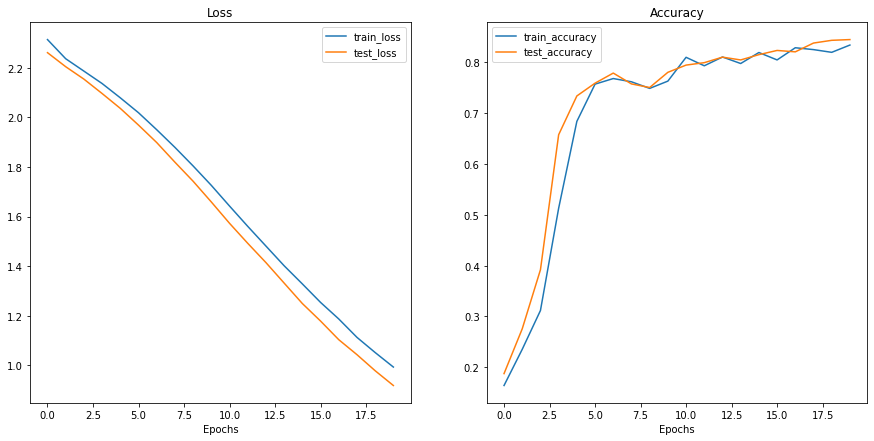

In [363]:
plot_loss_curves(model_sigmoid_3_layer_results)

### training model_tanh_3_layers with l2 regularization

In [364]:
# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_tanh_3_layers.parameters(), lr=0.001)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_tanh_3_layer_results = train(model=model_tanh_3_layers, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        device=device,
                        loss_fn=loss_fn, 
                        acc_fn=acc_fn,
                        epochs=NUM_EPOCHS,
                        regularizer=l2_penalty)


# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9855 | train_acc: 0.4437 | test_loss: 1.7153 | test_acc: 0.5926
Epoch: 2 | train_loss: 1.5542 | train_acc: 0.7061 | test_loss: 1.3756 | test_acc: 0.7747
Epoch: 3 | train_loss: 1.2537 | train_acc: 0.7988 | test_loss: 1.1020 | test_acc: 0.8424
Epoch: 4 | train_loss: 1.0062 | train_acc: 0.8650 | test_loss: 0.8899 | test_acc: 0.8672
Epoch: 5 | train_loss: 0.8253 | train_acc: 0.8457 | test_loss: 0.7241 | test_acc: 0.8935
Epoch: 6 | train_loss: 0.6655 | train_acc: 0.8799 | test_loss: 0.5881 | test_acc: 0.8899
Epoch: 7 | train_loss: 0.5433 | train_acc: 0.9141 | test_loss: 0.4687 | test_acc: 0.9200
Epoch: 8 | train_loss: 0.4532 | train_acc: 0.9174 | test_loss: 0.4000 | test_acc: 0.9220
Epoch: 9 | train_loss: 0.3784 | train_acc: 0.9086 | test_loss: 0.3512 | test_acc: 0.9353
Epoch: 10 | train_loss: 0.3265 | train_acc: 0.9181 | test_loss: 0.2897 | test_acc: 0.9423
Epoch: 11 | train_loss: 0.2752 | train_acc: 0.9165 | test_loss: 0.2361 | test_acc: 0.9319
Epoch: 12 | train_l

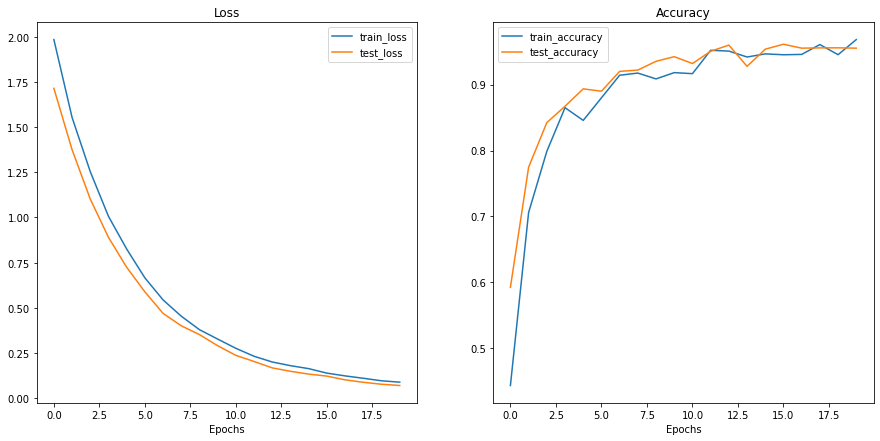

In [365]:
plot_loss_curves(model_tanh_3_layer_results)

### making model object

In [366]:
model_sigmode_3_layers_with_drop_out_25 = GurNumModel0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = 3,
    activation_funtion = nn.Sigmoid(),
    use_drop_prob=0.25
    ).to(device)
print("\nMODEL INFO: \n")
print(model_sigmode_3_layers_with_drop_out_25)


MODEL INFO: 

GurNumModel0(
  (block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=16, bias=True)
    (2): Sigmoid()
    (3): MyDropout()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Sigmoid()
    (6): MyDropout()
    (7): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [367]:
model_tanh_3_layers_with_drop_out_25 = GurNumModel0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = 3,
    activation_funtion = nn.Tanh(),
    use_drop_prob=0.25
    ).to(device)
print("\nMODEL INFO: \n")
print(model_tanh_3_layers_with_drop_out_25)


MODEL INFO: 

GurNumModel0(
  (block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=16, bias=True)
    (2): Tanh()
    (3): MyDropout()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Tanh()
    (6): MyDropout()
    (7): Linear(in_features=16, out_features=10, bias=True)
  )
)


### train loop for model_sigmoid_3_layers with dropout = 0.25

In [368]:
# training model_sigmoid_3_layer with drop outs prob. 0.25 
# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
# loss_fn = mcross_entropy_loss_with_L1()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_sigmode_3_layers_with_drop_out_25.parameters(), lr=0.001)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_sigmode_3_layers_with_drop_out_25_results = train(model=model_sigmode_3_layers_with_drop_out_25, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        device=device,
                        loss_fn=loss_fn, 
                        acc_fn=acc_fn,
                        epochs=NUM_EPOCHS)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3256 | train_acc: 0.0960 | test_loss: 2.2781 | test_acc: 0.1938
Epoch: 2 | train_loss: 2.2702 | train_acc: 0.1372 | test_loss: 2.2316 | test_acc: 0.2835
Epoch: 3 | train_loss: 2.2302 | train_acc: 0.1861 | test_loss: 2.1871 | test_acc: 0.3348
Epoch: 4 | train_loss: 2.1815 | train_acc: 0.2565 | test_loss: 2.1416 | test_acc: 0.4592
Epoch: 5 | train_loss: 2.1291 | train_acc: 0.2857 | test_loss: 2.0901 | test_acc: 0.4701
Epoch: 6 | train_loss: 2.0963 | train_acc: 0.2721 | test_loss: 2.0343 | test_acc: 0.4292
Epoch: 7 | train_loss: 2.0371 | train_acc: 0.3176 | test_loss: 1.9790 | test_acc: 0.4179
Epoch: 8 | train_loss: 1.9817 | train_acc: 0.3054 | test_loss: 1.9191 | test_acc: 0.4163
Epoch: 9 | train_loss: 1.9203 | train_acc: 0.3326 | test_loss: 1.8588 | test_acc: 0.4420
Epoch: 10 | train_loss: 1.8674 | train_acc: 0.3732 | test_loss: 1.8049 | test_acc: 0.5163
Epoch: 11 | train_loss: 1.8314 | train_acc: 0.3685 | test_loss: 1.7512 | test_acc: 0.5366
Epoch: 12 | train_l

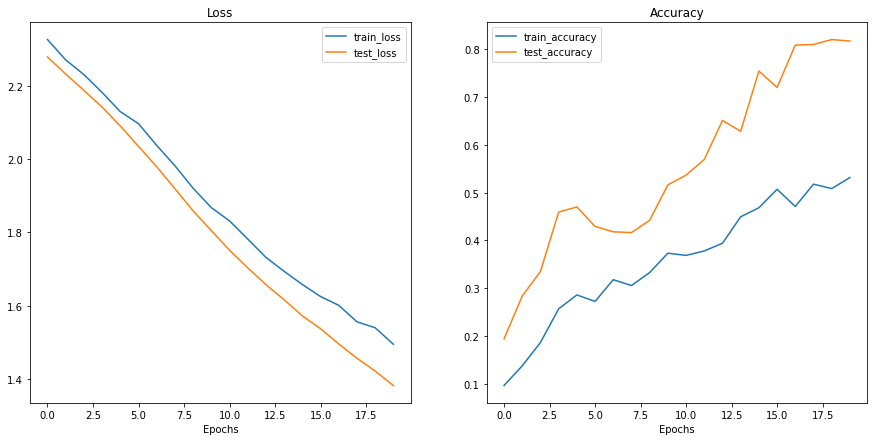

In [369]:
plot_loss_curves(model_sigmode_3_layers_with_drop_out_25_results)

### train loop for model_tanh_3_layers with dropout = 0.25

In [370]:
# training model_tanh_3_layer with drop outs prob. 0.25 
# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
# loss_fn = mcross_entropy_loss_with_L1()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_tanh_3_layers_with_drop_out_25.parameters(), lr=0.001)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_tanh_3_layers_with_drop_out_25_results = train(model=model_tanh_3_layers_with_drop_out_25, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        device=device,
                        loss_fn=loss_fn, 
                        acc_fn=acc_fn,
                        epochs=NUM_EPOCHS)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2041 | train_acc: 0.1766 | test_loss: 2.0240 | test_acc: 0.4626
Epoch: 2 | train_loss: 1.9293 | train_acc: 0.4217 | test_loss: 1.6979 | test_acc: 0.7929
Epoch: 3 | train_loss: 1.6306 | train_acc: 0.6694 | test_loss: 1.4475 | test_acc: 0.8288
Epoch: 4 | train_loss: 1.3794 | train_acc: 0.7674 | test_loss: 1.1951 | test_acc: 0.8886
Epoch: 5 | train_loss: 1.2025 | train_acc: 0.8465 | test_loss: 1.0015 | test_acc: 0.9052
Epoch: 6 | train_loss: 1.0445 | train_acc: 0.8635 | test_loss: 0.8381 | test_acc: 0.9054
Epoch: 7 | train_loss: 0.9196 | train_acc: 0.8615 | test_loss: 0.6801 | test_acc: 0.9177
Epoch: 8 | train_loss: 0.8072 | train_acc: 0.8894 | test_loss: 0.5744 | test_acc: 0.9110
Epoch: 9 | train_loss: 0.6783 | train_acc: 0.8666 | test_loss: 0.4788 | test_acc: 0.9197
Epoch: 10 | train_loss: 0.6227 | train_acc: 0.8855 | test_loss: 0.4112 | test_acc: 0.9255
Epoch: 11 | train_loss: 0.5458 | train_acc: 0.9132 | test_loss: 0.3378 | test_acc: 0.9169
Epoch: 12 | train_l

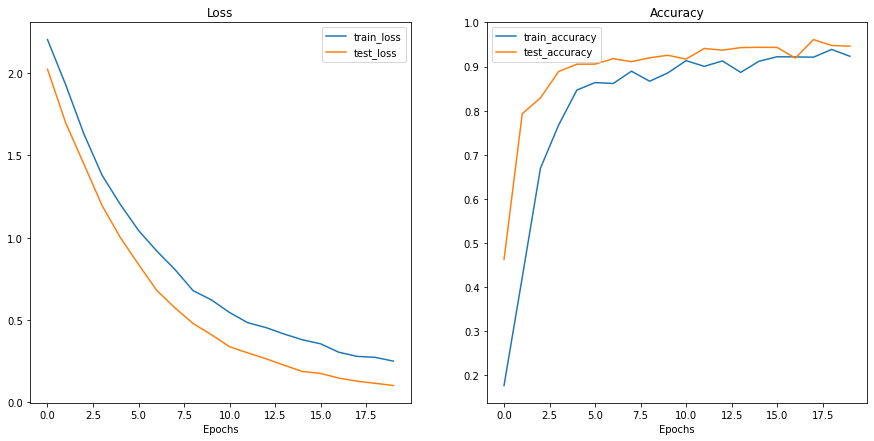

In [371]:
plot_loss_curves(model_tanh_3_layers_with_drop_out_25_results)

### making model object

In [372]:
model_sigmode_3_layers_with_drop_out_25 = GurNumModel0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = 3,
    activation_funtion = nn.Sigmoid(),
    use_drop_prob=0.25
    ).to(device)
print("\nMODEL INFO: \n")
print(model_sigmode_3_layers_with_drop_out_25)


MODEL INFO: 

GurNumModel0(
  (block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=16, bias=True)
    (2): Sigmoid()
    (3): MyDropout()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Sigmoid()
    (6): MyDropout()
    (7): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [373]:
model_tanh_3_layers_with_drop_out_25 = GurNumModel0(
    in_channels = height*width,
    hidden_units = 16,
    out_channels = len(class_names),
    num_layers = 3,
    activation_funtion = nn.Tanh(),
    use_drop_prob=0.25
    ).to(device)
print("\nMODEL INFO: \n")
print(model_tanh_3_layers_with_drop_out_25)


MODEL INFO: 

GurNumModel0(
  (block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=16, bias=True)
    (2): Tanh()
    (3): MyDropout()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Tanh()
    (6): MyDropout()
    (7): Linear(in_features=16, out_features=10, bias=True)
  )
)


### gradiant checking

In [374]:
# training model_sigmoid_3_layer with drop outs prob. 0.25 
# init. epochs
NUM_EPOCHS = 2

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
# loss_fn = mcross_entropy_loss_with_L1()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_sigmode_3_layers_with_drop_out_25.parameters(), lr=0.001)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

print("the execution will throw an error if grad. was not calculate corrected!!!")
# train model
model_sigmode_3_layers_with_drop_out_25_results = train(model=model_sigmode_3_layers_with_drop_out_25, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        device=device,
                        loss_fn=loss_fn, 
                        acc_fn=acc_fn,
                        epochs=NUM_EPOCHS,
                        cheack_grad=True # For cheaking grad calculations
                        )

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)

the execution will throw an error if grad. was not calculate corrected!!!


  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-341-7f6d21f4fb37>:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  theta = np.array([i.grad.detach().numpy() for i in model.parameters()])


Epoch: 1 | train_loss: 2.3169 | train_acc: 0.1095 | test_loss: 2.2882 | test_acc: 0.1623


<ipython-input-341-7f6d21f4fb37>:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual_grad = np.array([i.grad.detach().numpy() for i in model.parameters()])
<ipython-input-341-7f6d21f4fb37>:92: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  dm = (np.average([np.linalg.norm(i) in actual_grad]) + np.average([np.linalg.norm(i) for i in grad_approx]))/2


Epoch: 2 | train_loss: 2.2834 | train_acc: 0.1488 | test_loss: 2.2426 | test_acc: 0.2233
total training time: 2.019 sec.
